<a href="https://colab.research.google.com/github/hanbiphyun/ESSA_YB/blob/main/ESAA_YB_%EB%AF%B8%EB%8B%88%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B83.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#미니 프로젝트 (3)
##영화 관객 수 예측 경진대회
- 회귀 알고리즘을 이용하여 예측하기

###1. 전처리

In [29]:


# 한글 폰트 설정
# 나눔 바른 고딕 폰트 설치
!apt-get update -qq
!apt-get install fonts-nanum -qq
!sudo fc-cache -fv
!rm -rf ~/.cache/matplotlib
import matplotlib.pyplot as plt # Add this line
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False # 마이너스 기호 깨짐 방지
print("한글 폰트 설정 완료")


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/nanum: skipping, looped dire

In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt # Add this line
plt.rc('font', family='NanumBarunGothic') #matplotlib 한글 깨짐 방지

import warnings
warnings.filterwarnings(action='ignore')

In [31]:
import pandas as pd
train= pd.read_csv('movies_train.csv')
train.head(5)

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083
3,나는 공무원이다,(주)NEW,코미디,2012-07-12,101,전체 관람가,구자홍,23894.00,2,20,6,217866
4,불량남녀,쇼박스(주)미디어플렉스,코미디,2010-11-04,108,15세 관람가,신근호,1.00,1,251,2,483387


In [32]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           600 non-null    object 
 1   distributor     600 non-null    object 
 2   genre           600 non-null    object 
 3   release_time    600 non-null    object 
 4   time            600 non-null    int64  
 5   screening_rat   600 non-null    object 
 6   director        600 non-null    object 
 7   dir_prev_bfnum  270 non-null    float64
 8   dir_prev_num    600 non-null    int64  
 9   num_staff       600 non-null    int64  
 10  num_actor       600 non-null    int64  
 11  box_off_num     600 non-null    int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 56.4+ KB


In [33]:
train.describe()

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
count,600.000000,2.700000e+02,600.000000,600.000000,600.000000,6.000000e+02
mean,100.863333,1.050443e+06,0.876667,151.118333,3.706667,7.081818e+05
std,18.097528,1.791408e+06,1.183409,165.654671,2.446889,1.828006e+06
min,45.000000,1.000000e+00,0.000000,0.000000,0.000000,1.000000e+00
25%,89.000000,2.038000e+04,0.000000,17.000000,2.000000,1.297250e+03
50%,100.000000,4.784236e+05,0.000000,82.500000,3.000000,1.259100e+04
75%,114.000000,1.286569e+06,2.000000,264.000000,4.000000,4.798868e+05
max,180.000000,1.761531e+07,5.000000,869.000000,25.000000,1.426277e+07


##결측치 확인

In [34]:
train.isna().sum()

,0
title,0
distributor,0
genre,0
release_time,0
time,0
screening_rat,0
director,0
dir_prev_bfnum,330
dir_prev_num,0
num_staff,0


### 이전 영화 박스오피스 수 (dir_prev_num)의 na 값 0으로 채움

In [35]:

train.dir_prev_bfnum.fillna(0, inplace=True)

###release_time 을 날짜로 인식하도록 변경하고 년,월, 일 구별하는 피처 생성

In [36]:
train['release_time']= pd.to_datetime(train['release_time'])
train['year']= train['release_time'].dt.year
train['month']= train['release_time'].dt.month
train['weekday']= train['release_time'].dt.day_of_week
# 0~6 : 월요일~일요일

train.head(5)

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,year,month,weekday
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,0.00,0,91,2,23398,2012,11,3
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501,2015,11,3
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083,2013,6,2
3,나는 공무원이다,(주)NEW,코미디,2012-07-12,101,전체 관람가,구자홍,23894.00,2,20,6,217866,2012,7,3
4,불량남녀,쇼박스(주)미디어플렉스,코미디,2010-11-04,108,15세 관람가,신근호,1.00,1,251,2,483387,2010,11,3


X, y 정의 및 데이터 세트 분리

In [37]:
y = train['box_off_num']
X = train.drop('box_off_num', axis=1)

from sklearn.model_selection import train_test_split
RANDOM=0

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM
)

### 배급사 (distributor) 피처를 재정의하기
- 적은 영화를 배급하는 배급사들을 하나로 묶어보기

In [38]:
train['distributor'].value_counts()

,count
distributor,
CJ 엔터테인먼트,54
롯데엔터테인먼트,52
(주)NEW,30
(주)마운틴픽쳐스,29
(주)쇼박스,26
...,...
영화사 廊,1
크리에이티브컴즈(주),1
ysfilm,1


In [39]:
dist_counts= train['distributor'].value_counts()

bins= [0,5,10,15,20,25, dist_counts.max()]

distribution = pd.cut(dist_counts, bins=bins, right=True).value_counts().sort_index()

print(distribution)

count
(0, 5]      144
(5, 10]      17
(10, 15]      2
(15, 20]      0
(20, 25]      0
(25, 54]      6
Name: count, dtype: int64


생각보다 영화를 적게 배급한 배급사가 많다.

In [40]:
one_dist= dist_counts[dist_counts==1]
one_dist

,count
distributor,
(주)두타연,1
유니버설픽쳐스인터내셔널코리아,1
CGV 무비꼴라쥬,1
(주)팝 파트너스,1
콘텐츠판다,1
...,...
영화사 廊,1
크리에이티브컴즈(주),1
ysfilm,1


- 1개의 영화 배급한 배급사가 102개

In [41]:
two_dist= dist_counts[dist_counts==2]
two_dist

,count
distributor,
드림로드,2
리틀빅픽쳐스,2
(주)프레인글로벌,2
노바엔터테인먼트,2
조이앤시네마,2
CJ E&M Pictures,2
백두대간,2
파이오니아21,2
CGV 아트하우스,2


- 2개 영화 배급한 배급사 20개

### 영화 1개만 배급한 배급사들을 하나의 값으로 묶기
-> 다른 방법 : 1~2개 배급한 배급사 묶기
=> rare_dist= dist_counts[dist_counts<=2].index

In [42]:
rare_dist= dist_counts[dist_counts==1].index

train['distributor_processed']= train['distributor'].apply(
    lambda x : 'rare_distributor' if x in rare_dist else x
)

train.head(10)  # 피처 생성 확인

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,year,month,weekday,distributor_processed
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,0.00,0,91,2,23398,2012,11,3,롯데엔터테인먼트
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501,2015,11,3,(주)쇼박스
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083,2013,6,2,(주)쇼박스
3,나는 공무원이다,(주)NEW,코미디,2012-07-12,101,전체 관람가,구자홍,23894.00,2,20,6,217866,2012,7,3,(주)NEW
4,불량남녀,쇼박스(주)미디어플렉스,코미디,2010-11-04,108,15세 관람가,신근호,1.00,1,251,2,483387,2010,11,3,쇼박스(주)미디어플렉스
5,강철대오 : 구국의 철가방,롯데엔터테인먼트,코미디,2012-10-25,113,15세 관람가,육상효,837969.00,2,262,4,233211,2012,10,3,롯데엔터테인먼트
6,길위에서,백두대간,다큐멘터리,2013-05-23,104,전체 관람가,이창재,0.00,0,32,5,53526,2013,5,3,백두대간
7,회사원,(주)쇼박스,액션,2012-10-11,96,청소년 관람불가,임상윤,739522.00,3,342,2,1110523,2012,10,3,(주)쇼박스
8,"1789, 바스티유의 연인들",유니버설픽쳐스인터내셔널코리아,뮤지컬,2014-09-18,129,전체 관람가,정성복,0.00,0,3,5,4778,2014,9,3,rare_distributor
9,청춘그루브,(주)두타연,드라마,2012-03-15,94,15세 관람가,변성현,0.00,0,138,3,868,2012,3,3,rare_distributor


### 상관관계가 높거나 불필요한 피처 제거

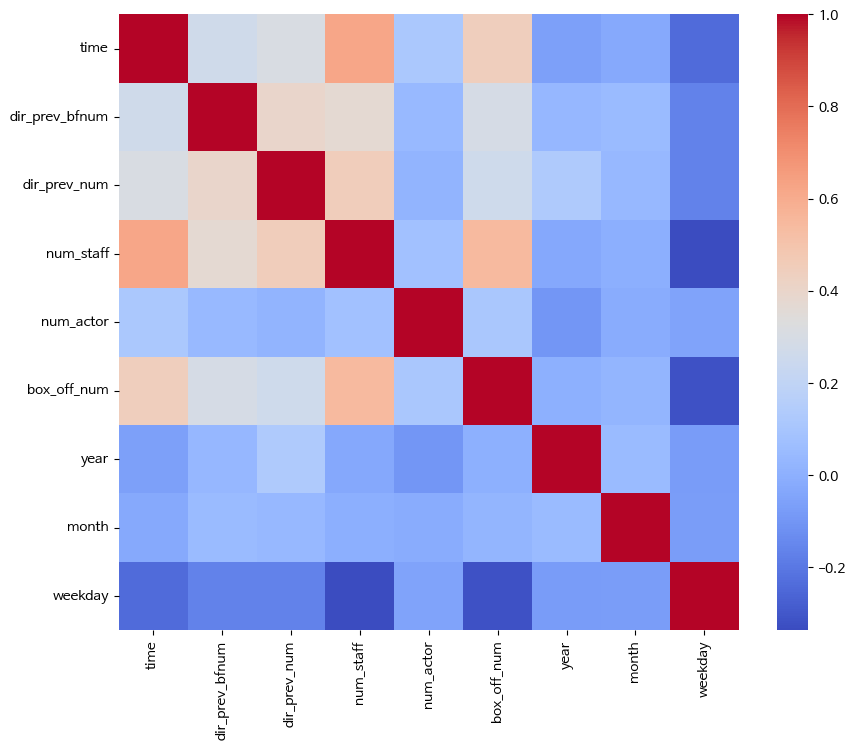

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = train.corr(numeric_only=True)

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.show()


In [44]:
import numpy as np

# 상관계수 행렬
corr_matrix = train.corr(numeric_only=True).abs()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# 기준 이상이면 제거 리스트에 추가
to_drop = [column for column in upper.columns if any(upper[column] > 0.6)]

print("제거 후보:", to_drop)

train_reduced = train.drop(columns=to_drop)


제거 후보: ['num_staff']


- 상관계수가 0.6 이상인 변수 num_staff 하나뿐 -> 선택해서 드랍해도 되고 안해도 될듯

In [45]:
numeric_cols = train.select_dtypes(include=['number'])
numeric_cols.corr()['num_staff'].sort_values(ascending=False)


,num_staff
num_staff,1.000000
time,0.623205
box_off_num,0.544265
dir_prev_num,0.450706
dir_prev_bfnum,0.369657
num_actor,0.077871
month,-0.002841
year,-0.032891
weekday,-0.336794


- 피처별 분포 모양을 보고 로그변환 해주기

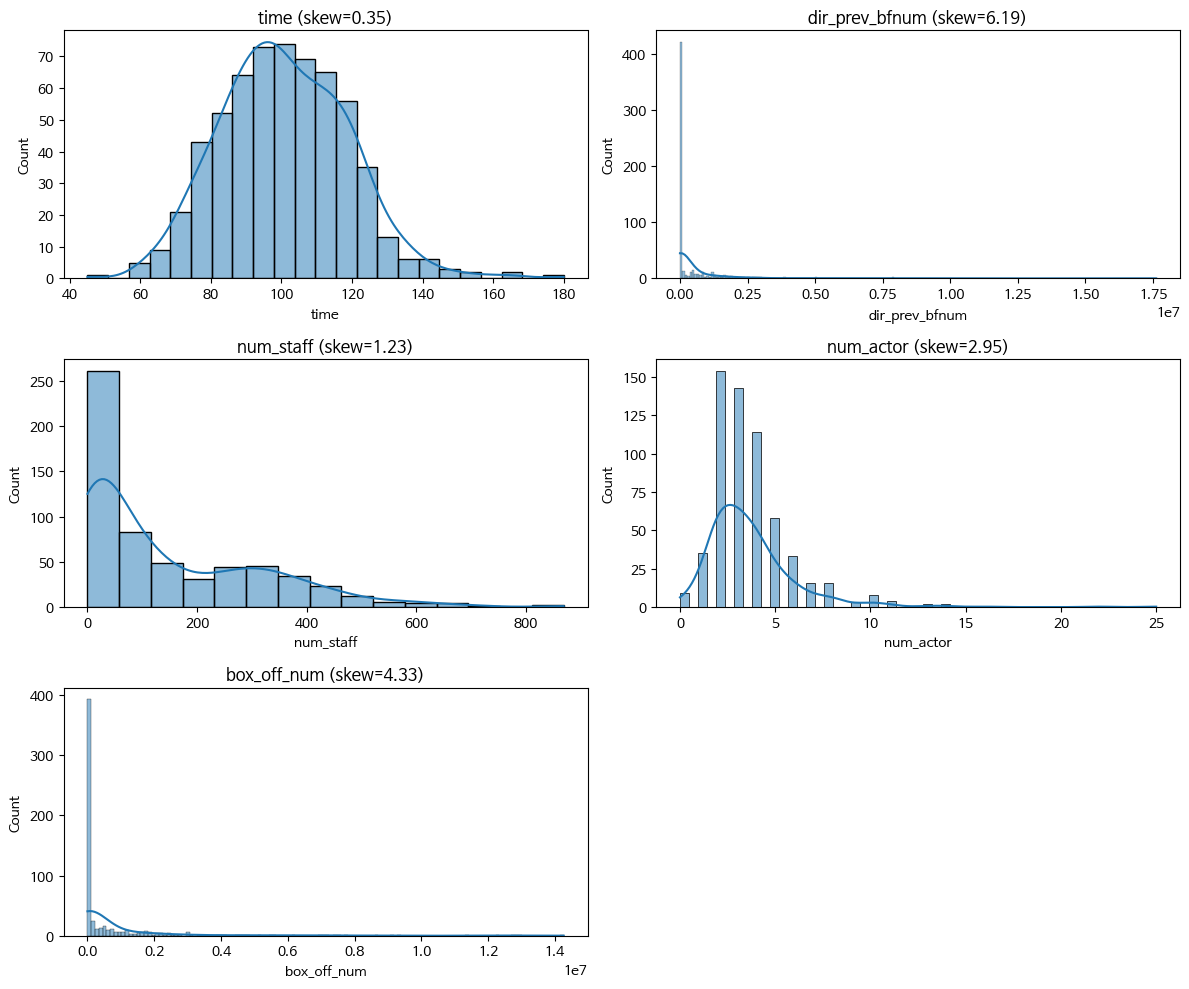

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

cols = ['time', 'dir_prev_bfnum',
        'num_staff', 'num_actor', 'box_off_num']

plt.figure(figsize=(12, 10))

for i, col in enumerate(cols, 1):
    plt.subplot(3, 2, i)
    sns.histplot(train[col], kde=True)
    plt.title(f"{col} (skew={train[col].skew():.2f})")

plt.tight_layout()
plt.show()

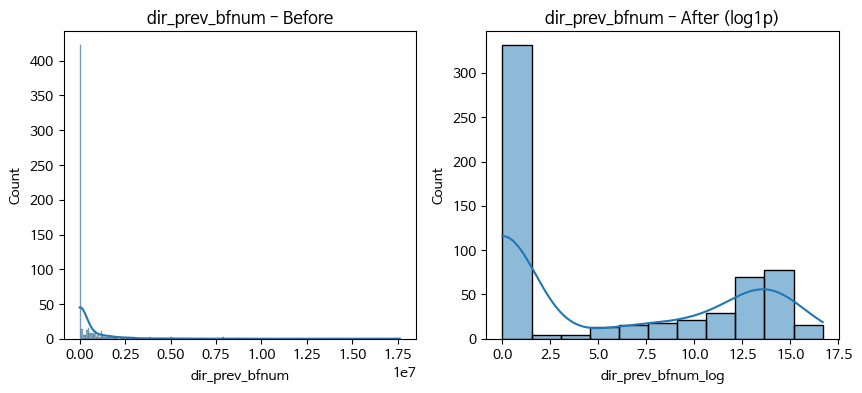

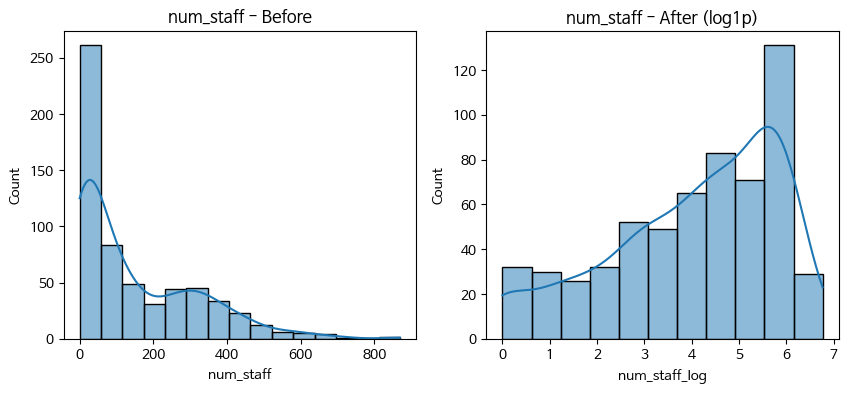

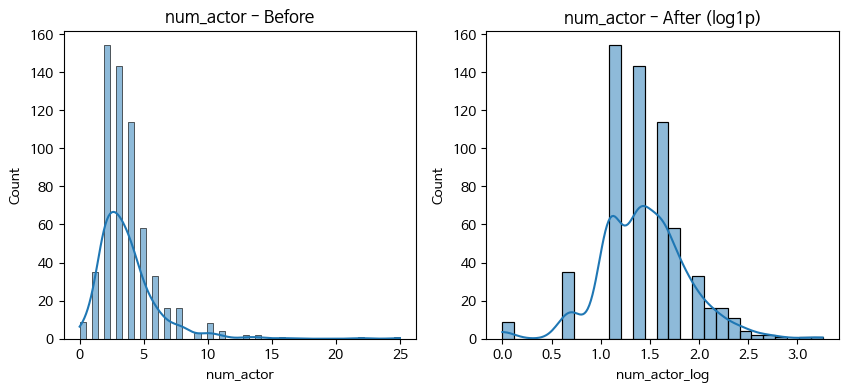

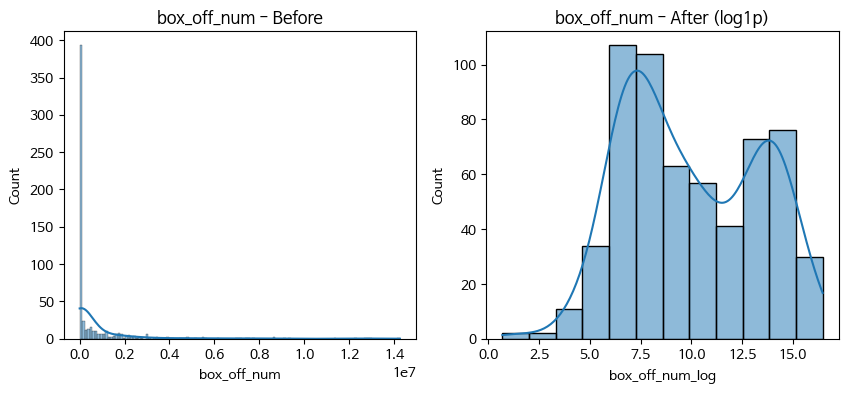

In [47]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

cols_to_transform = ['dir_prev_bfnum', 'num_staff', 'num_actor', 'box_off_num']

# 변환 전후 분포 비교
for col in cols_to_transform:
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))

    sns.histplot(train[col], ax=ax[0], kde=True)
    ax[0].set_title(f"{col} - Before")

    # log1p 변환 (log(x+1))
    train[col + "_log"] = np.log1p(train[col])

    sns.histplot(train[col + "_log"], ax=ax[1], kde=True)
    ax[1].set_title(f"{col} - After (log1p)")

    plt.show()


- 분포가 안정적으로 바뀐 box_off_num_log, num_actor_log 피처는 로그변환하면 좋을듯.
- 나머지 dir_prev_bfnum, num_staff 는 로그변환해도 치우친 모습 -> 선택하면 될듯

### 피처 생성
- 감독의 과거 평균 흥행

In [64]:
# 감독별 과거 평균 흥행
director_mean = X_train.join(y_train).groupby('director')['box_off_num'].mean()
overall_mean = y_train.mean()

# train에 적용
X_train['director_mean_bo'] = X_train['director'].map(director_mean)

# valid는 train에서 만든 평균을 그대로 사용
X_valid['director_mean_bo'] = X_valid['director'].map(director_mean)
X_valid['director_mean_bo'].fillna(overall_mean, inplace=True)


train_df = pd.concat([X_train, y_train], axis=1)   # train에 y 합쳐서 확인용 DataFrame 생성


In [65]:
#피처 생성확인
train_df[['director', 'box_off_num', 'director_mean_bo']].head()


,director,box_off_num,director_mean_bo
118,심형래,2541603,2.541603e+06
362,최동훈,12983841,1.284525e+07
55,권칠인,986287,6.145143e+05
90,김대우,1441990,2.213773e+06
390,이광국,3591,3.591000e+03


In [67]:
train_df[train_df['director'] == '봉준호'][['director','box_off_num', 'director_mean_bo']]

,director,box_off_num,director_mean_bo
496,봉준호,9350351,9350351.0


In [68]:
train_df['director_mean_bo'].isna().sum(), X_valid['director_mean_bo'].isna().sum()

#결측치 없음

(np.int64(0), np.int64(0))

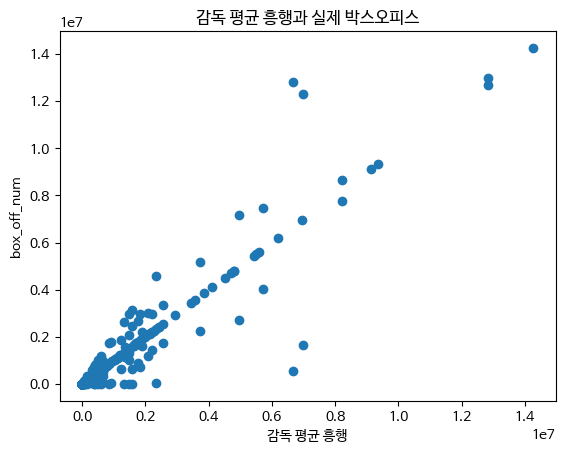

In [69]:
import matplotlib.pyplot as plt

plt.scatter(train_df['director_mean_bo'], train_df['box_off_num'])
plt.xlabel('감독 평균 흥행')
plt.ylabel('box_off_num')
plt.title('감독 평균 흥행과 실제 박스오피스')
plt.show()


- 산점도 그래프가 우상향 하는 것으로 보아 추가한 director_mean_bo 피처는 유의미한 것으로 보임 -> 사용해도 될듯